In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
data_path = os.path.join('/content/drive', 'My Drive', 'FinalProjData')

**Step 1: Applying Preprocessing Techniques:**

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define paths(Konrad Began coding here)
data_path = '/content/drive/My Drive/FinalProjData/test'
malignant_path = os.path.join(data_path, 'malignant')
benign_path = os.path.join(data_path, 'benign')

def preprocess_image(image_path):
  image = cv2.imread(image_path)
  image = cv2.resize(image, (224, 224))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  image = clahe.apply(image)
  image = image / 255.0
  image = image.astype(np.uint8)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  return image

def augment_image(image):
  image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  return image

# Lists to store processed images/labels
images = []
labels = []

for folder_path, label in [(malignant_path, 1), (benign_path, 0)]:  # 1 for malignant, 0 for benign
  for image_file in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_file)

    preprocessed_image = preprocess_image(image_path)

    augmented_image = augment_image(preprocessed_image)

    images.append(augmented_image)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

**Step 2: Existing Method: VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Split data into training and testing sets(Chibuzo Began coding here)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

#New classification head
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) # Binary classification

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 377s 22s/step - accuracy: 0.5142 - loss: 0.8388 - val_accuracy: 0.5379 - val_loss: 0.7016
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 365s 21s/step - accuracy: 0.4463 - loss: 0.7405 - val_accuracy: 0.5379 - val_loss: 0.7413
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 391s 22s/step - accuracy: 0.5075 - loss: 0.7631 - val_accuracy: 0.5455 - val_loss: 0.7165
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 370s 21s/step - accuracy: 0.5594 - loss: 0.6890 - val_accuracy: 0.4318 - val_loss: 0.7610
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 394s 22s/step - accuracy: 0.5220 - loss: 0.7214 - val_accuracy: 0.5379 - val_loss: 0.7189
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 380s 22s/step - accuracy: 0.5102 - loss: 0.7039 - val_accuracy: 0.4242 - val_loss: 0.7372
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 366s 22s/step - accuracy: 0.4845 - loss: 0.7012 - val_accuracy: 0.5076 - val_loss: 0.7233
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 367s 22s/step -

**Step 3: Evaluation**

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.7557
Test Accuracy: 0.5000


**Step 4: Now, given our results we need to work on a new model which will give us greater results. We will use the EfficientNet-B0 architecture for this**

In [ ]:
!pip install keras-tuner
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Step 1: Load and Preprocess Images(Chibuzo Began Coding here)
data_path = '/content/drive/My Drive/FinalProjData/test'
malignant_path = os.path.join(data_path, 'malignant')
benign_path = os.path.join(data_path, 'benign')

def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)
        images.append(image)
    return np.array(images)

# Get image paths and labels
images_paths = []
labels = []

for folder_path, label in [(malignant_path, 1), (benign_path, 0)]:
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        images_paths.append(image_path)
        labels.append(label)

labels = np.array(labels)

# Step 2: Split and Load Data
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    images_paths, labels, test_size=0.2, random_state=42, stratify=labels)

X_train = load_and_preprocess_images(X_train_paths)
X_test = load_and_preprocess_images(X_test_paths)

# Step 3: Data Augmentation(Konrad Began coding here)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_test, y_test, batch_size=32)

# Step 4: Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Step 5: Build EfficientNetB0 Model (Fine-Tuned)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train the Model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights_dict
)
# Step 7: Evaluate the Model
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 268s 13s/step - accuracy: 0.4908 - loss: 0.7391 - val_accuracy: 0.4773 - val_loss: 0.7814
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 193s 11s/step - accuracy: 0.5066 - loss: 0.7359 - val_accuracy: 0.4621 - val_loss: 0.7541
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 186s 11s/step - accuracy: 0.5633 - loss: 0.6791 - val_accuracy: 0.4167 - val_loss: 0.7303
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 189s 11s/step - accuracy: 0.6358 - loss: 0.6407 - val_accuracy: 0.4621 - val_loss: 0.7130
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 201s 12s/step - accuracy: 0.6137 - loss: 0.6539 - val_accuracy: 0.5227 - val_loss: 0.6939
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 190s 11s/step - accuracy: 0.6074 - loss: 0.6313 - val_accuracy: 0.5530 - val_loss: 0.6754
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 189s 11s/step - accuracy: 0.6078 - loss: 0.6422 - val_accuracy: 0.6061 - val_loss: 0.6537
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 198s 12s/step - accuracy: 0.6247 - loss: 0.6181 - val_accuracy: 0.

*Step 5: We must compare our results to see how exactly our models compare to each other*

In [ ]:
from sklearn.metrics import f1_score

# Store results in a dictionary(Chibuzo started to code here)
results = {
    'VGG16': {'loss': 0.7557, 'accuracy': 0.5000},
    'EfficientNet-B0': {'loss': 0.5912, 'accuracy': 0.7803}
}

# Function to estimate F1 score based on accuracy
def estimate_f1_from_accuracy(accuracy):
    tpr = accuracy
    fpr = 1 - accuracy
    precision = tpr / (tpr + fpr)
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

# Calculate F1 scores
for model_name, metrics in results.items():
    metrics['f1'] = estimate_f1_from_accuracy(metrics['accuracy'])

# Print a comparison table with F1 score
print("Model Comparison:")
print("{:<15} {:<10} {:<10} {:<10}".format("Model", "Loss", "Accuracy", "F1 Score"))
print("-" * 45)
for model_name, metrics in results.items():
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f}".format(model_name, metrics['loss'], metrics['accuracy'], metrics['f1']))

Model Comparison:
Model           Loss       Accuracy   F1 Score  
---------------------------------------------
VGG16           0.7557     0.5000     0.5000    
EfficientNet-B0 0.5912     0.7803     0.7803    


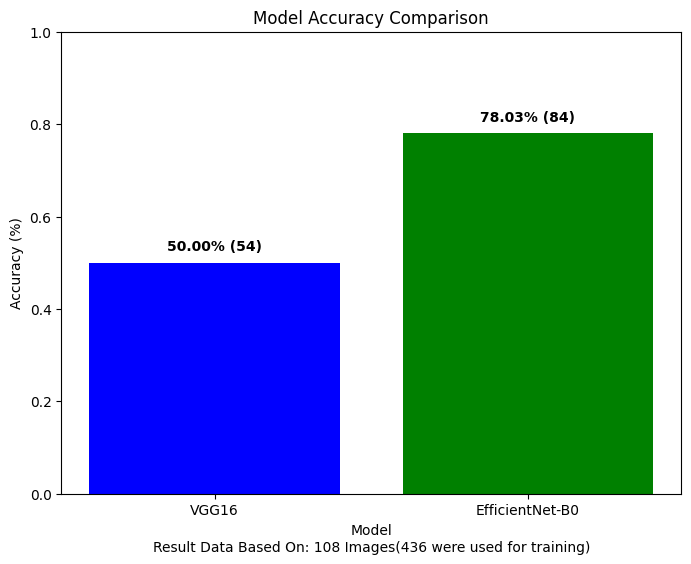

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Store results in a dictionary(Konrad started to code here)
results = {
    'VGG16': {'loss': 0.7557, 'accuracy': 0.5000},
    'EfficientNet-B0': {'loss': 0.5912, 'accuracy': 0.7803}
}

# Total number of images in the test set (544 total images and 80/20 split)
total_test_images = int(544 * 0.2)  # 20% for testing

# Extract model names and accuracies for plotting
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]

# Create the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1)


for bar, accuracy in zip(bars, accuracies):
    correct_predictions = int(accuracy * total_test_images)
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.02,
             f'{accuracy * 100:.2f}% ({correct_predictions})',
             ha='center', va='bottom', fontweight='bold')

plt.text(0.5, -0.1, f'Result Data Based On: 108 Images(436 were used for training)',
         ha='center', va='top', transform=plt.gca().transAxes)

plt.show()